In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install timm

In [ ]:
from fastai.vision.all import *

In [ ]:
import zipfile
import os

def unzip_file(zip_path, extract_to):
    """
    Unzips a ZIP file to the specified directory.

    Args:
    zip_path (str): Path to the ZIP file.
    extract_to (str): Directory to extract the files to.
    """
    try:
        # Open the zip file
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            # Extract all the contents into the directory
            zip_ref.extractall(extract_to)
            print(f"Files extracted to {extract_to}")
    except zipfile.BadZipFile:
        print("Error: Invalid ZIP file!")
    except FileNotFoundError:
        print("Error: ZIP file not found!")
    except Exception as e:
        print(f"An error occurred: {e}")

# Example usage
zip_path = '/content/drive/MyDrive/Final Data.zip'
extract_to = 'Final Data'

# Ensure the extraction directory exists
if not os.path.exists(extract_to):
    os.makedirs(extract_to)

unzip_file(zip_path, extract_to)

Files extracted to Final Data


In [ ]:
df = pd.read_csv('/content/Final Data/Final Data/processed_image_labels.csv')
df.head()

,Eye ID,Label
0,TRAIN000000,NRG
1,TRAIN000001,NRG
2,TRAIN000002,NRG
3,TRAIN000003,NRG
4,TRAIN000004,NRG


In [ ]:


# Path to where your images are stored
path = Path('/content/Final Data/Final Data/Final_RG_NRG')  # Update this path to your images directory

# Load the CSV file
df = pd.read_csv('/content/Final Data/Final Data/processed_image_labels.csv')  # Update the path to your CSV file

# Assuming 'Eye ID' needs to be appended with '.jpg' to form the full image filename
df['image_path'] = df['Eye ID'].apply(lambda x: f"{x}.JPG")

# Setup ImageDataLoaders
dls = ImageDataLoaders.from_df(df,
                               path=path,
                               fn_col='image_path',
                               label_col='Label',
                               valid_pct=0.2,
                               seed=42,
                               suff='',
                               item_tfms=Resize(224))

# Show a batch of images to verify


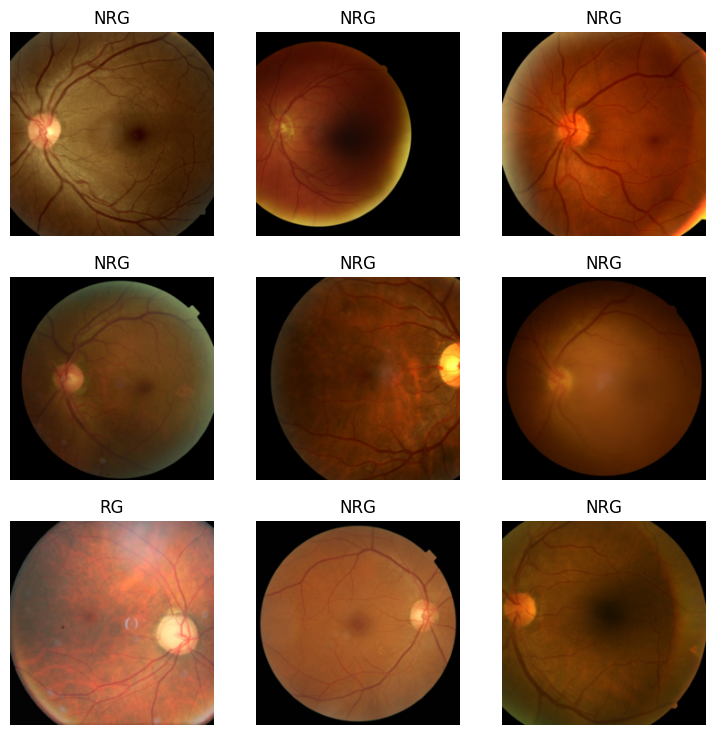

In [ ]:
dls.show_batch()

In [ ]:
learn = vision_learner(dls, resnet50, metrics=[error_rate,accuracy])
learn.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.185711,0.804187,0.252500,0.747500,04:53


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.786330,0.727561,0.245000,0.755000,04:04
1,0.599555,0.651059,0.220000,0.780000,04:30


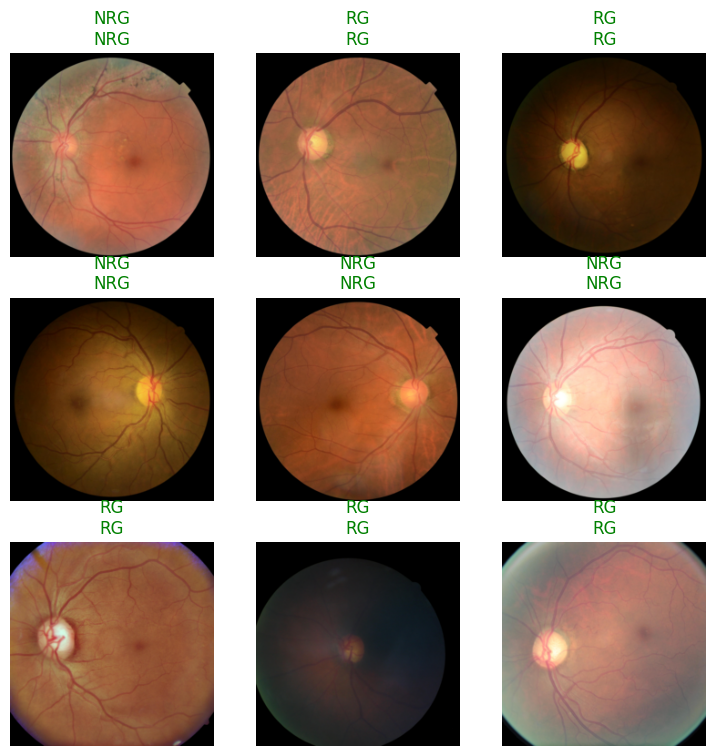

In [ ]:
learn.show_results()

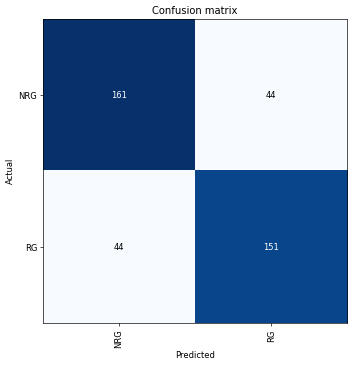

In [ ]:
ClassificationInterpretation.from_learner(learn).plot_confusion_matrix(figsize=(6,6), dpi=60)

In [ ]:
def get_ensemble(nmodels):
    ens_model = [] # Empty List of ensemble model, I will store the trained learner object here
    # learning_rate =[2.95e-02,3e-02,3e-02] # List of learning rate for each model
    model_list = [resnet18, resnet34, resnet50] ##List of Models . You can add resnet ones in the mix
    for i in range(nmodels):
        print(f'-----Training model: {i+1}--------')

        learn = vision_learner(dls, model_list[i], metrics=[error_rate,accuracy])
        learn.fine_tune(3)
        ens_model.append(learn)
        print(f'-----Training of model {i+1} complete----')
    return ens_model

In [ ]:
ens = get_ensemble(3)

-----Training model: 1--------


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 91.5MB/s]


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.915502,0.716621,0.295000,0.705000,04:18


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.708832,0.691070,0.280000,0.720000,04:13
1,0.597240,0.552549,0.200000,0.800000,04:12
2,0.458608,0.591548,0.215000,0.785000,04:14


-----Training of model 1 complete----
-----Training model: 2--------


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 159MB/s]


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.003316,0.684019,0.270000,0.730000,04:12


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.708444,0.703800,0.242500,0.757500,04:12
1,0.550421,0.624241,0.210000,0.790000,04:16
2,0.402865,0.597452,0.215000,0.785000,04:15


-----Training of model 2 complete----
-----Training model: 3--------


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.067873,0.859631,0.330000,0.670000,04:16


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.859153,0.771752,0.277500,0.722500,04:18
1,0.679507,0.708455,0.247500,0.752500,04:19
2,0.518335,0.643452,0.240000,0.760000,04:15


-----Training of model 3 complete----


In [ ]:
predictions = []
for model in ens:
  prediction = model.get_preds(dl = dls.valid)
  predictions.append(prediction)


In [ ]:
correct_predictions = 0
total_predictions = 0

In [ ]:
num_models = len(predictions)
batch_size = predictions[0][0].shape[0]

# Convert probabilities to class indices
predictions_classes = [torch.max(probs, dim=1)[1] for probs, _ in predictions]

# Majority vote
majority_votes = torch.zeros(batch_size, dtype=torch.long)
for i in range(batch_size):
    # Count votes for each class
    votes = torch.zeros(2, dtype=torch.int32)  # assuming binary classification
    for model_predictions in predictions_classes:
        votes[model_predictions[i]] += 1

    # Determine the class with the maximum votes
    majority_votes[i] = torch.argmax(votes)

# Calculate accuracy
correct_predictions = 0
total_predictions = 0
for _, labels in predictions:
    correct_predictions += (majority_votes == labels).sum().item()
    total_predictions += labels.size(0)

# Calculate and print accuracy
accuracy = correct_predictions / total_predictions
print(f"Accuracy of the majority voting classifier: {accuracy:.4f}")

Accuracy of the majority voting classifier: 0.8050
